**cloud field panels for E3SM or CESM by differencing experiment and control**

In [27]:
import sys
print(sys.version)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import cartopy.crs as ccrs

# load some useful functions written or acquired by phil rasch
%run -i ./pjrlib

3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]


<Figure size 640x480 with 0 Axes>

In [28]:
# open a file that will hold all the filenames used by the program
flname = '/tmp/flname'
file = open(flname, 'w')
file.write('list of files used by Cloudfields_xxx\n')
file.close()
file = open(flname, 'a')

In [29]:
def setfig3b1x1 ():
    """
    return fig and axes for a single panel figure
    """
    plotproj = ccrs.Mollweide(central_longitude=-80)
    plotproj._threshold /= 100.
    fig, axes = plt.subplots(ncols=1,
                             gridspec_kw={'width_ratios': [1]},
                             subplot_kw={'projection': plotproj},
                             figsize=(6,4.1),
                            )
    fig.set_dpi(300.0)
    return fig, axes;

def pltllbox(xri, yri,ax=None):
    if ax is None:
        ax = plt.gca()
    if xri[1] < xri[0]:
        xri[1] += 360.
    regcx = [xri[0],xri[1],xri[1],xri[0],xri[0]]
    regcy = [yri[0],yri[0],yri[1],yri[1],yri[0]]
    ax.plot(regcx,regcy,color='red',transform=ccrs.PlateCarree())

In [30]:
def xr_llhplot2 (xrVar, cbar='default', plotproj=None, ax=None, cax=None, fig=None,
                 ylabels=False, clevs=None, cmap=None, title=None, cbartitle=None):
    """xr_llhplot xarray lat lon horizontal plot
    """
    #print(' entering xr_llhplot', xrVar)
    
    lon=xrVar['lon'].values
    lat=xrVar['lat'].values
    xv,yv=np.meshgrid(lon,lat)
    data_regridded = xrVar.values
    #print('aaa',data_regridded.shape, xv.shape, yv.shape)
    df = data_regridded.flatten()
    dsub = df[np.isfinite(df)] # ignore NaN
    zmax = dsub.max()
    zmin = dsub.min()
    #print('masked interpolated range',zmin,zmax)
    dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
    if ylabels is None: ylabels = True
    if clevs is None:
        clevs = findNiceContours(np.array([zmin,zmax]),nlevs=10)
    #print('clevs',clevs)
    if cmap is None:
        #print('aaa, grabbing cmap default')
        #cmap = mpl.cm.get_cmap()
        cmap = plt.get_cmap()
        #print('bbb',cmap.N)
    #print('cmap',cmap)
    extend = 'both'
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N,extend=extend)
    #print('norm',norm(clevs))
    clat = (lat.min()+lat.max())/2.
    clon = (lon.min()+lon.max())/2.
    if plotproj is None:
        plotproj = ccrs.PlateCarree()
        plotproj = ccrs.Mollweide()
 
    # if no ax argument, could get current axis, or create it
    if ax is None:
        #print('grab current axis')
        #ax = plt.gca()
        ax = plt.axes(projection=plotproj)
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=2, color='gray', alpha=0.5)
    pl = ax.contourf(xv, yv, data_regridded, levels=clevs, # vmin=zmin, vmax=zmax,
                     norm=norm, cmap=cmap,
                     extend=extend, transform=ccrs.PlateCarree())
    
    gl.left_labels=ylabels
    gl.right_labels=ylabels
    ax.coastlines(linewidth=1,color='blue')
 
    ## Find the location of the main plot axes
    ## has to be done after some plotting is done in projection space
    posn = ax.get_position()
    
    # print some registration marks to help in lining up figures
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.scatter([0,0,1,1], [0,1,0,1], c="r", s=100)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])

    if not title is None:
        #ax.set_title(title)
        ax2.text(0.01,0.9,title)
    
    # Add colorbar to plot
    if cbartitle is None:
        cbartitle = xrVar.long_name
        
    if cbar == 'default':
        if cax is not None:
            cax = ax
        else:
            # create an colorbar axis
            cax = fig.add_axes([0,0,0.1,0.1])
            ## Adjust the positioning and orientation of the colorbar
            cax.set_position([posn.x0, posn.y0-0.07, posn.width, 0.05])

        cb = plt.colorbar(
             pl, orientation='horizontal',ticks=clevs,cax=cax,
             label='%s (%s)'%(cbartitle, xrVar.units),
             )
        cb.ax.tick_params(labelsize=11)
        #cb.ax.set_yticklabels(['{:.0f}'.format(x) for x in clevs])#, fontsize=16, weight='bold')
        if len(clevs) > 15:
            clevs2 = findNiceContours(clevs,nlevs = 10, rmClev=0.,sym=True)
            cb.set_ticks(clevs2)
            cb.set_ticklabels(clevs2)
            #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            cb.ax.set_xticklabels(["{:.0f}".format(i) for i in clevs2]) # set ticks of your format


        
    return

In [31]:
def pltfld(DV, titled, fname=None):
    
    cbartitle = DV.long_name
    
    if DV.min().values == DV.max().values:
        print('constant field skipping plot ')
    else:
        dlev_rng = {'CDNUMC':np.array([0.,3.e11])/2.,'FSNT':np.array([-45.,45.]),
                   'TGCLDLWP':np.array([-50.,50.]),'PRECL':np.array([-1.,1.]),
                    #'TGCLDLWP':np.array([-80.,80.]),'PRECL':np.array([-1.,1.]),
                    'PRECT':np.array([-5.,5.]),'SWCF':np.array([-45.,45.]),
                    'CLDLOW':np.array([-10.,10.]),'XXX':np.array([-45.,45.]),
                    'CLDTOT':np.array([-10.,10.]),'FSNTC':np.array([-20.,20.]),

                   }
        if DV.name in dlev_rng:
            dlevs = findNiceContours(dlev_rng[DV.name],nlevs = 15,rmClev=0.,sym=True)
        else:
            dlevs = findNiceContours(np.array([DV.min().values,DV.max().values]),nlevs = 15, rmClev=0.,sym=True)
        #dlevs = [-5.,-2.,-1.,-0.5,-0.2,-0.1,0.1,0.2,0.5,1.,2.,5.]
        #print('xxx',dlevs)
        dmap = diverge_map()

        plconf = '3-1x1'
        #plconf = '1x3'
        # good setup for 1 row of 3 columns
        # good setup for 3 rows of 1 columns
        if plconf == '3-1x1':
            fig, axes = setfig3b1x1()
            xr_llhplot2(DV, fig=fig, ax=axes,clevs=dlevs,cmap=dmap,title=titled, cbartitle=cbartitle)
            pltllbox([-150.,-110.],[0.,30.],ax=axes)
            pltllbox([-110.,-70.],[-30.,0.],ax=axes)
            pltllbox([-25.,15.],[-30.,0.],ax=axes)
            if fname is not None:
                print('fname',fname)
                plt.savefig(fname,dpi=300,transparent=True)
            plt.show()




-------------------------------CLDTOT
opening ind1  /e3sm_prod/phil/climo/e3sm/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_ANN_000101_001112_climo_fv192x288.nc
opening ind2 /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.CLDTOT.nc
DV range -3.7613754 4.2728844
CLDTOT Vertically-integrated total cloud Range V1 and V2  17.912264 98.40008 17.30398 98.709305
area avgs E3SM_50Tgpy 67.66  E3SMcontrol 67.63  Delta  0.03
fname E3SM_50Tgpy_CLDTOT-D.pdf


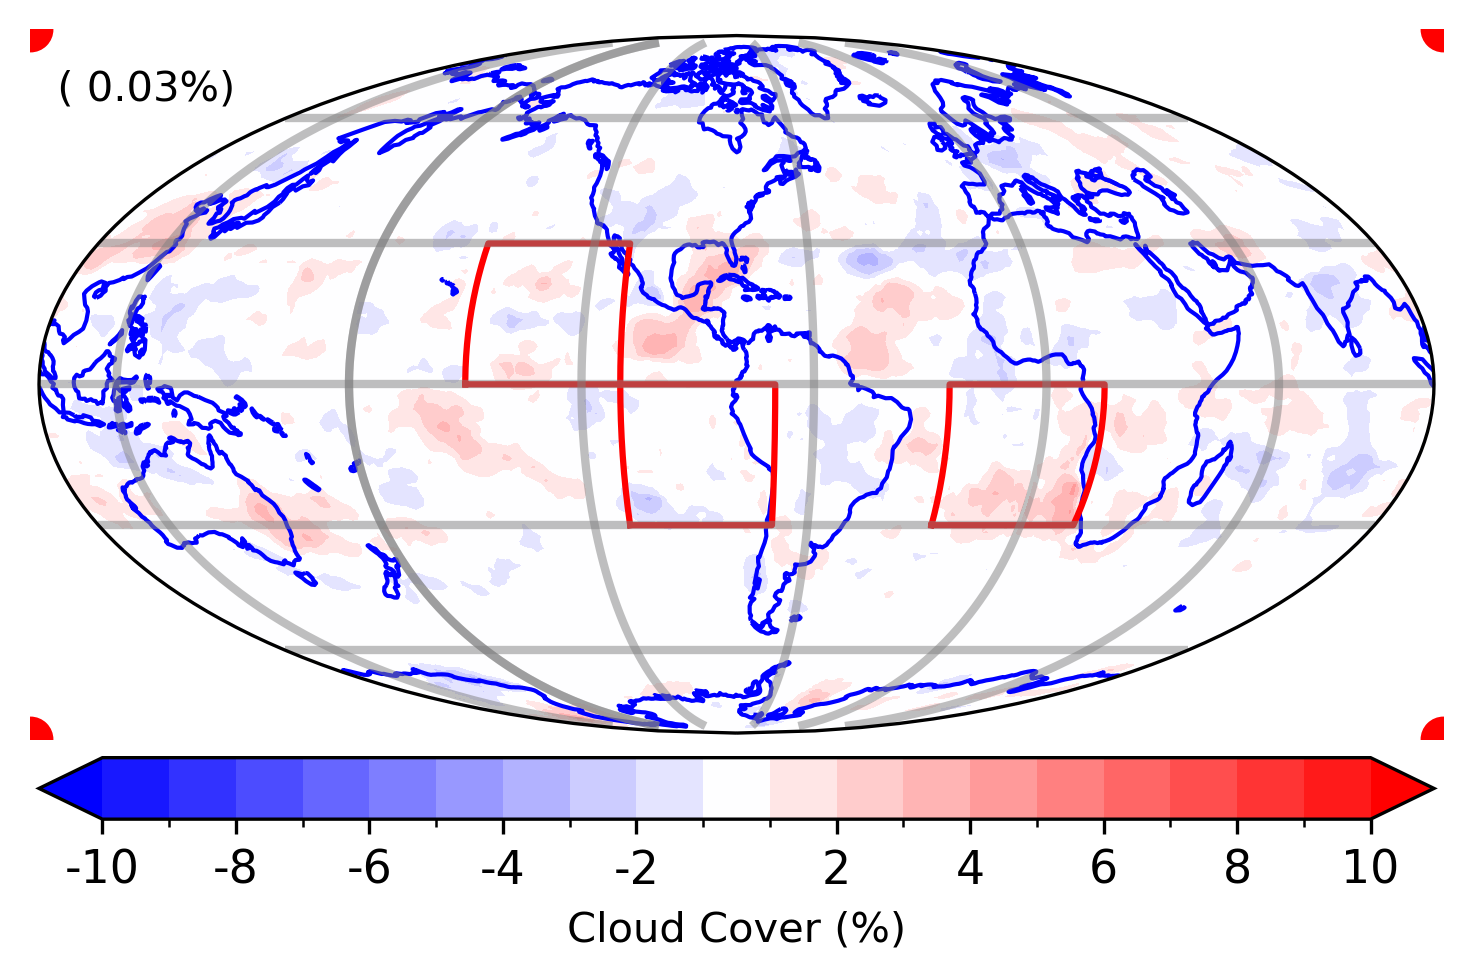

field processing complete

-------------------------------TGCLDLWP
opening ind1  /e3sm_prod/phil/climo/e3sm/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_ANN_000101_001112_climo_fv192x288.nc
opening ind2 /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.TGCLDLWP.nc
DV range -8.966454 24.051254
TGCLDLWP grid-avg LWP. Range V1 and V2  0.035106488 169.83807 0.04667979 162.09862
area avgs E3SM_50Tgpy 55.07  E3SMcontrol 54.33  Delta  0.74
fname E3SM_50Tgpy_TGCLDLWP-D.pdf


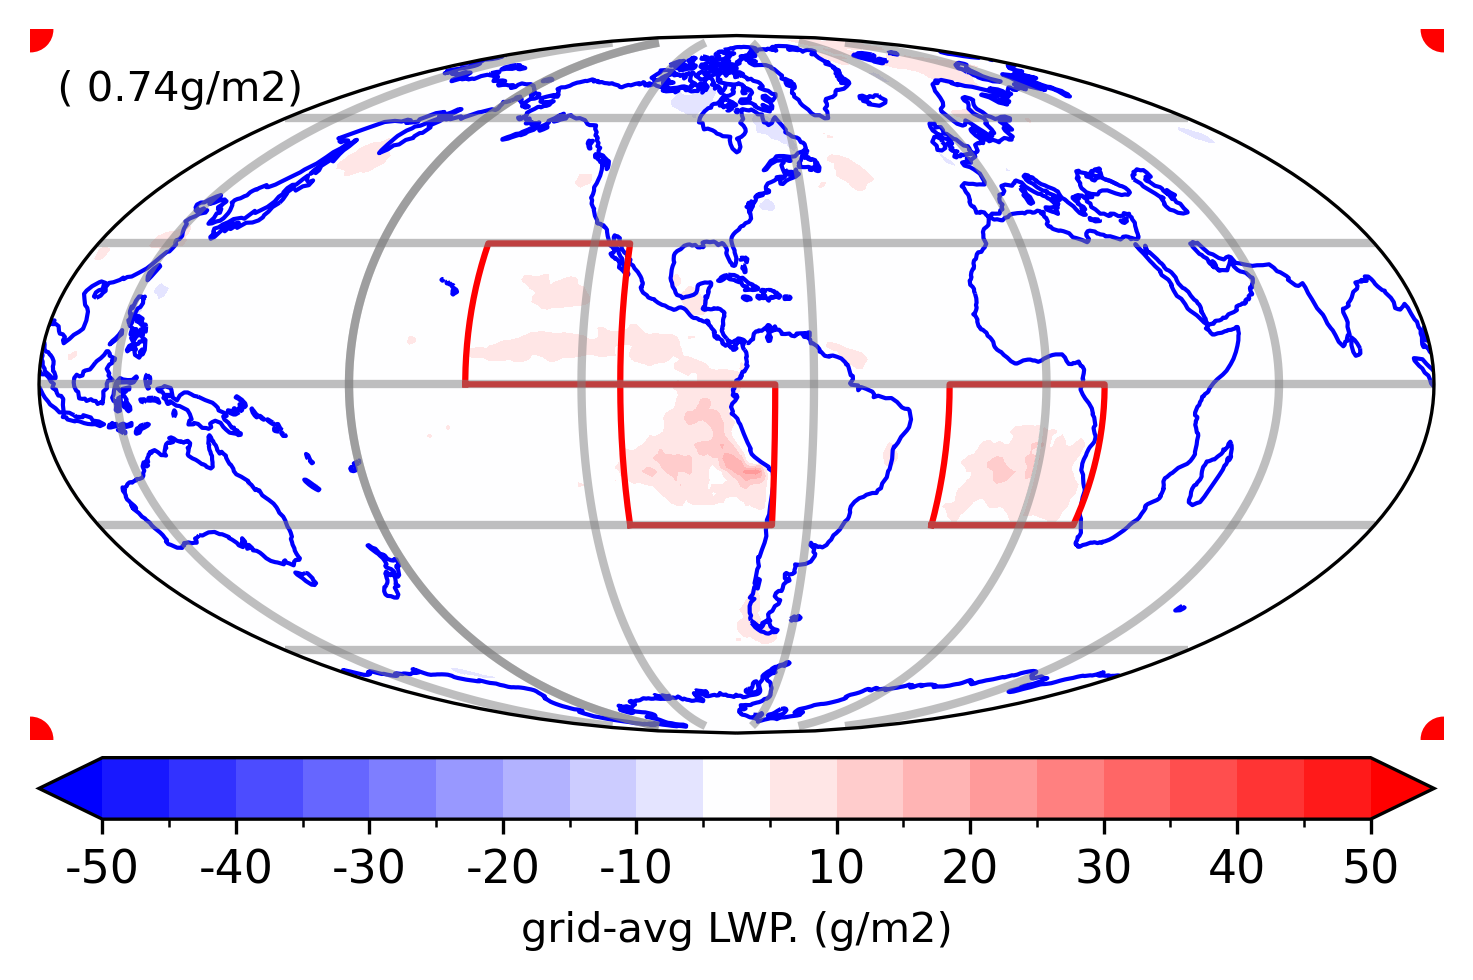

field processing complete

-------------------------------FSNT
opening ind1  /e3sm_prod/phil/climo/e3sm/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_ANN_000101_001112_climo_fv192x288.nc
opening ind2 /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FSNT.nc
DV range -39.391876 7.531433
FSNT Net solar flux at top of model Range V1 and V2  50.647556 355.35974 50.9661 357.5863
area avgs E3SM_50Tgpy 238.67  E3SMcontrol 240.54  Delta -1.87
fname E3SM_50Tgpy_FSNT-D.pdf


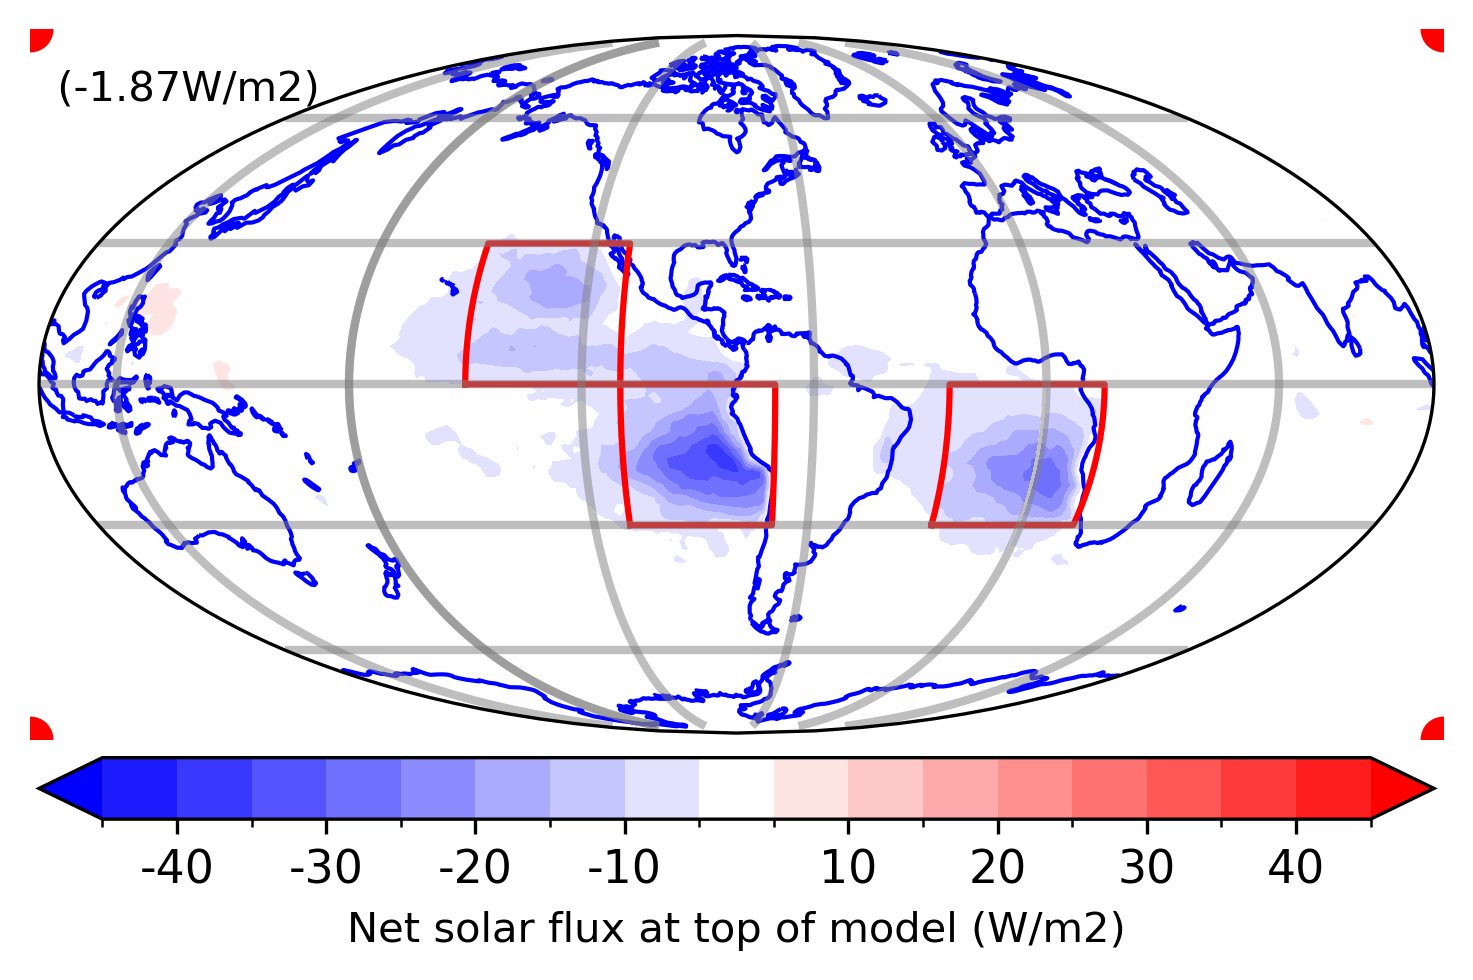

field processing complete

-------------------------------FSNTC
opening ind1  /e3sm_prod/phil/climo/e3sm/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_ANN_000101_001112_climo_fv192x288.nc
opening ind2 /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FSNTC.nc
DV range -10.125 6.282898
FSNTC Clearsky net solar flux at top of model Range V1 and V2  50.959652 377.5227 51.308327 377.95914
area avgs E3SM_50Tgpy 287.46  E3SMcontrol 288.27  Delta -0.81
fname E3SM_50Tgpy_FSNTC-D.pdf


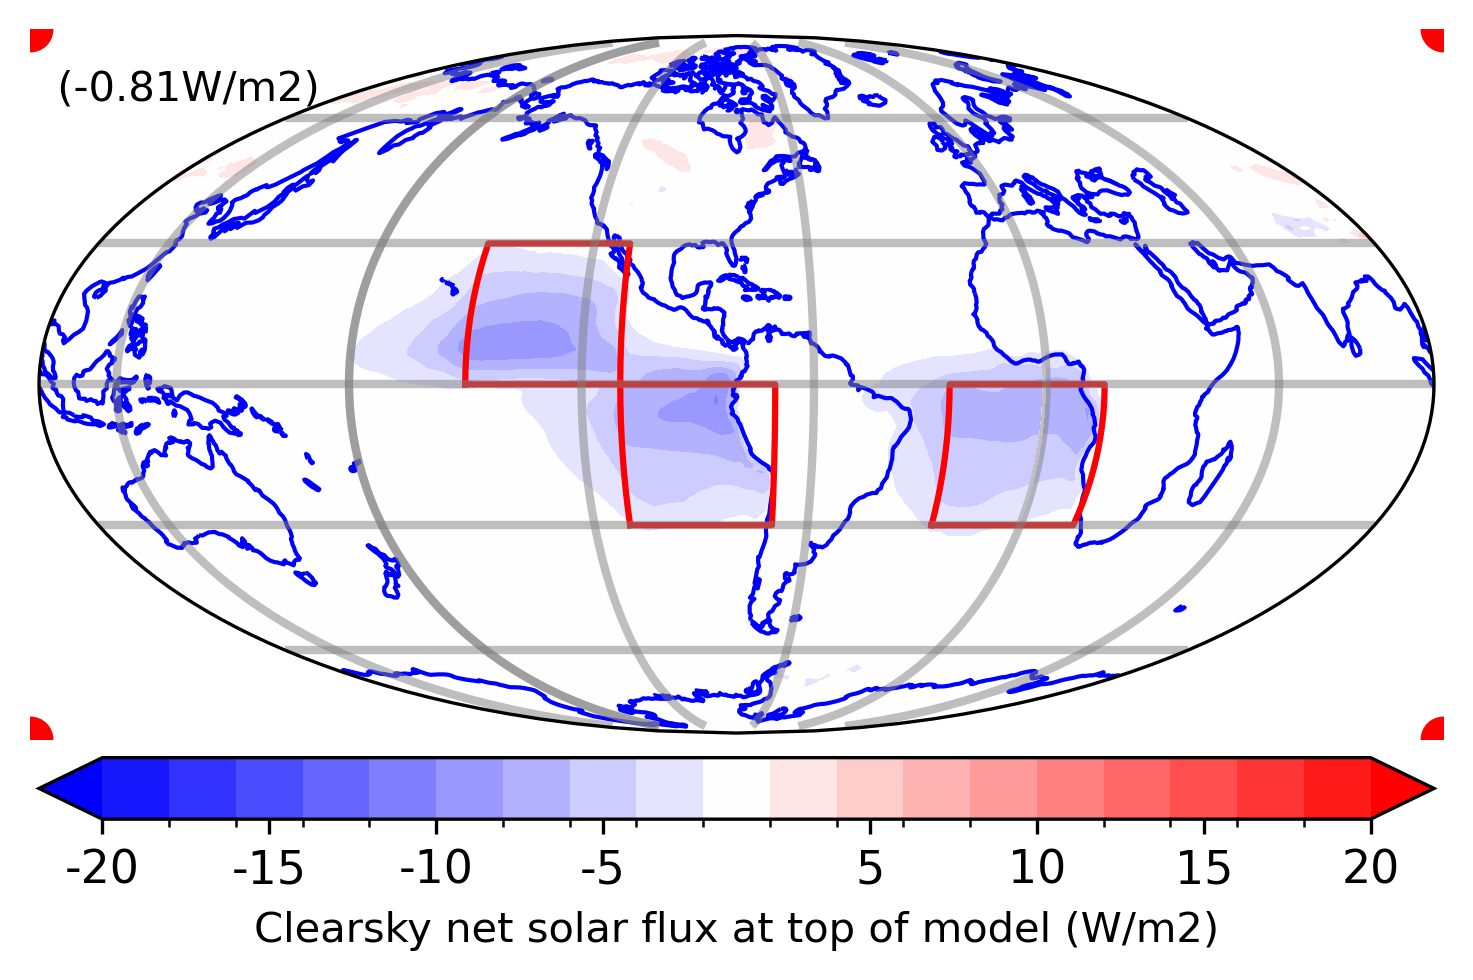

field processing complete


In [32]:


regtag = ""
weights = None

Varlist = np.array(['CLDTOT','TGCLDLWP','FSNT','FSNTC'])


# specify regions (assume lon always specified as west, then east limit)
xreg = np.array([[-150.,-110.],[-110,-70],[-25.,15.],[170.,-120.],[-170.,-90.]])%360.
yreg = np.array([[0.,30.],     [-30.,0.], [-30.,0.], [30.,50.],   [-50.,-30.] ])
namereg = ['NEP','SEP','SEA','NP','SP']

    
if True: # E3SM 50Tg/yr
    case_start1 = "/e3sm_prod/phil/climo/e3sm/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/20230426.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_ANN_000101_001112_climo_fv192x288.nc"
    case_end1 = ""
    pref1='E3SM_50Tgpy'
    fstring1 ='%s%.0s%.0s' 
    #fstring1 ='%s%s%s' 

    case_start2 = "/e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/fv192x288/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14."
    case_end2 = ".nc"
    fstring2 ='%s%.0s%.0s' 
    fstring2 ='%s%s%s' 
    pref2='E3SMcontrol'

if False: # CESM 7.5 Tg/yr
    case_start1 = "/e3sm_prod/phil/climo/cesm/F2010climo.ss_NEP_SEP_SEA.1.5Tg/fv192x288/F2010climo.ss_NEP_SEP_SEA.1.5Tg.cam.h0."
    case_end1 = ".1-25.nc"
    pref1='CESM_7.5Tgpyr'
    fstring1 ='%s%.0s%.0s' 
    fstring1 ='%s%s%s' 

    case_start2 = "/e3sm_prod/phil/climo/cesm/Fixed_SST/fv192x288/Fixed_SST.cam.h0.1-20."
    case_end2 = ".nc"
    fstring2 ='%s%.0s%.0s' 
    fstring2 ='%s%s%s' 
    pref2='CESMcontrol'


for Varname in Varlist:
    print()
    print('-------------------------------'+Varname)    
    ind1 = fstring1 % (case_start1,Varname,case_end1)
    file.write(ind1+'\n')
    print('opening ind1 ',ind1)
    DS1 = xr.open_mfdataset(ind1)
    #print('xxx',DS1.time)
    DS1 = center_time(DS1)
    Var1 = xr_getvar(Varname,DS1)
    V1 = Var1.mean(dim='time',keep_attrs=True)

    ind2 = fstring2 % (case_start2,Varname,case_end2)
    file.write(ind2+'\n')
    print('opening ind2',ind2)
    #DS2 = xr.open_mfdataset(ind2)
    DS2 = xr.open_mfdataset(ind2)

    #DS2 = center_time(DS2)
    Var2 = xr_getvar(Varname,DS2)
    #print('yyy',Var2)
    #print('yy2',Var2.lat)
    #print('yy3',Var2.time)
    V2 = Var2.mean(dim='time',keep_attrs=True)

    DV = V1-V2
    print('DV range', DV.min().values, DV.max().values)
    if 'area' in DS1:
        area = DS1['area']
    elif 'area' in DS2:
        area = DS2['area']
    else:
        print('calculating weights')
        lat = Var1['lat'].values
        lon = Var1['lon'].values
        area = make_fvarea(lon,lat)
    weights = V1.copy()
    weights.data =area
    weights.attrs['units']='steradians'
    
    print(Varname, V1.attrs['long_name'],'Range V1 and V2 ',V1.min().values, V1.max().values, V2.min().values, V2.max().values)
    V1A = V1.weighted(weights).mean()
    sV1A = ' (%5.2f)' % V1A
    V2A = V2.weighted(weights).mean()
    sV2A = ' (%5.2f)' % V2A
    DVA = V1A-V2A
    #sDVA = ' (%5.2f)' % DVA
    sDVA = ' ({:5.2f}{:s})'.format(DVA.values, DVA.units)

    print('area avgs '+pref1+' %5.2f' % (V1A.values),' '+pref2+' %5.2f' % (V2A.values),' Delta %5.2f' % (DVA.values))

    if V1.min().values == V1.max().values:
        print('constant field skipping plot ')
    else:
        clev_rng = {'CDNUMC':np.array([0.,3.e11]),'FSNT':np.array([40.,360]),
                    'TGCLDLWP':np.array([0.,280.]),'PRECL':np.array([0.,10.]),
                    'PRECC':np.array([0.,16.]),'SWCF':np.array([-140.,0.]),
                    'CLDLOW':np.array([0.,90.]),'AODVIS':np.array([0,0.2]),
                    'XXX':np.array([-45.,45.]),
                   }
        dlev_rng = {'CDNUMC':np.array([0.,3.e11])/2.,'FSNT':np.array([-45.,45.]),
                   'TGCLDLWP':np.array([-50.,50.]),'PRECL':np.array([-1.,1.]),
                    'PRECC':np.array([-1.,1.]),'SWCF':np.array([-45.,45.]),
                    'CLDLOW':np.array([-10.,10.]),'AODVIS':np.array([-.9,.9]),
                    'CLDTOT':np.array([-10.,10.]),'FSNTC':np.array([-20.,20.])
                   }
        if Varname in clev_rng:
            clevs = findNiceContours(clev_rng[Varname],nlevs = 12)
        else:
            clevs = findNiceContours(np.array([V1.values,V2.values]),nlevs = 12)
        if Varname in dlev_rng:
            dlevs = findNiceContours(dlev_rng[Varname],nlevs = 15,rmClev=0.,sym=True)
        else:
            dlevs = findNiceContours(np.array([DV.min().values,DV.max().values]),nlevs = 15, rmClev=0.,sym=True)
        #dlevs = [-5.,-2.,-1.,-0.5,-0.2,-0.1,0.1,0.2,0.5,1.,2.,5.]
        #print('xxx',dlevs)
        dmap = diverge_map()
        
        if Varname == 'CLDTOT':
            DV.attrs['long_name'] = "Cloud Cover"

        plconf = '3-1x1'
        #plconf = '1x3'

        # good setup for 1 row of 3 columns
        if plconf == '1x3':
            fig, axes = plt.subplots(ncols=3
                                     ,gridspec_kw={'width_ratios': [1, 1, 1]}
                                     ,subplot_kw={'projection': ccrs.Mollweide()}
                                     ,figsize=(16,5)
                                    )

            xr_llhplot(V1, ax=axes[0],clevs=clevs,title=pref1+sV1A)
            xr_llhplot(V2, ax=axes[1],clevs=clevs,ylabels=False,title=pref2+sV2A)
            xr_llhplot(DV, ax=axes[2],clevs=dlevs,cmap=dmap,title=pref1+'-'+pref2+sDVA)
            #plt.savefig(pref1+'_'+Varname+'.pdf',format='pdf',dpi=300)
            plt.show()
            
        # good setup for 3 rows of 1 columns
        if plconf == '3-1x1':
            
            if False:
                fig, axes = setfig3b1x1()
                #print('V1XXX',V1)
                xr_llhplot(V1, ax=axes,clevs=clevs,title=pref1+sV1A)
                pltllbox([-150.,-110.],[0.,30.])
                pltllbox([-110.,-70.],[-30.,0.])
                pltllbox([-25.,15.],[-30.,0.])
                plt.savefig(pref1+'_'+Varname+'.pdf',format='pdf',dpi=300)
                plt.show()

                fig, axes = setfig3b1x1()
                xr_llhplot(V2, ax=axes,clevs=clevs,ylabels=False,title=pref2+sV2A)
                pltllbox([-150.,-110.],[0.,30.])
                pltllbox([-110.,-70.],[-30.,0.])
                pltllbox([-25.,15.],[-30.,0.])
                plt.savefig(pref2+'_'+Varname+'.pdf',format='pdf',dpi=300)
                plt.show()

            if False:
                fig, axes = setfig3b1x1()
                xr_llhplot(DV, ax=axes,clevs=dlevs,cmap=dmap,title=pref1+'-'+pref2+sDVA)
                pltllbox([-150.,-110.],[0.,30.])
                pltllbox([-110.,-70.],[-30.,0.])
                pltllbox([-25.,15.],[-30.,0.])
                plt.savefig(pref1+'_'+Varname+'-D.pdf',format='pdf',dpi=300)
                plt.show()

            pref_fn = pref1
            difftitle = ''
            fname = pref_fn+'_'+DV.name+'-D.pdf'
            pltfld(DV, difftitle+sDVA,fname)

        
    print('field processing complete')

file.close()
